In [37]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [38]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.transformers.second_quantization.electronic.freeze_core_transformer import FreezeCoreTransformer

In [39]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import GroundStateEigensolver, QEOM, VQEUCCFactory

In [40]:
# This first part sets the ground state solver
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

In [58]:
# Distance between the Li and H atom:
# Cartesians from:
# https://cccbdb.nist.gov/exp2x.asp?casno=7580678&charge=0
d = 1.5949
# https://aip.scitation.org/doi/10.1063/1.1677704
a0 = 0.529177210903
a = 3.015 * a0
print(a)
#d = a # 1.595469 ( not so much difference )

1.595469290872545


Originally, we have these orbitals, H: 1s2, Li: 1s2, 2s2, 2px2, 2py2, 2pz2, total (spin) oribtals: 6 (12)

To reduce number of qubits, we align the H and Li atom to X axis so that there is no contribution of py (orbital 3) and pz (orbital 4).

Also, we freeze the core electrons so that 2 electrons from Li are occupied in the 1s2 (orbital 0).

Ref: https://arxiv.org/abs/1704.05018

In [59]:
molecule = Molecule(
    geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [d, 0.0, 0.0]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

# FreezeCoreTransformer will freeze core electrons by defaults
es_problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(remove_orbitals=[3, 4])])
qubit_converter = QubitConverter(ParityMapper(), True, [1, 1])

In [60]:
second_q_op = es_problem.second_q_ops()
print(second_q_op[0])

Fermionic Operator
register length=6, number terms=117
  (0.01301297176964477+0j) * ( +_0 -_1 +_3 -_4 )
+ (-0.03453981098528195+0j) * ( +_0 -_1 +_3 -_5 )
+ (-0.013012971769644775+0j) * ( +_0 -_1 -_3 +_4 )
+ (0.034539810985281916+0j) * ( +_0 -_1 -_3 +_ ...


In [61]:
qubit_op = qubit_converter.convert(second_q_op[0])
print(qubit_op)

-0.2071971919112127 * IIII
+ (-0.2534393552522031+1.3877787807814457e-17j) * ZIII
+ 0.013846702482966912 * IZII
- 0.046571665340751855 * ZZII
+ (-0.253439355252203-1.3877787807814457e-17j) * IIZI
+ 0.1134904741696194 * ZIZI
+ 0.11351147171736535 * IZZI
+ (0.060367117387170634+3.469446951953614e-18j) * ZZZI
+ (0.01384670248296688+3.469446951953614e-18j) * IIIZ
+ 0.11351147171736535 * ZIIZ
+ (0.1219161918168757+6.938893903907228e-18j) * IZIZ
+ 0.055938986157482405 * ZZIZ
- 0.04657166534075183 * IIZZ
+ 0.060367117387170634 * ZIZZ
+ (0.055938986157482405-3.469446951953614e-18j) * IZZZ
+ 0.0844840116206575 * ZZZZ
+ 0.010817614312880586 * XIII
- 0.010817614312880587 * XZII
+ 0.01101293743072889 * XIZI
- 0.01101293743072889 * XZZI
+ 0.012835066166227057 * XIIZ
- 0.012835066166227057 * XZIZ
- 0.008995487748531 * XIZZ
+ 0.008995487748531 * XZZZ
- 0.002564096134708268 * IXII
+ (0.0025640961347082676-1.0842021724855044e-19j) * ZXII
+ (0.010823229230178793-8.673617379884035e-19j) * IXZI
- 0.010823

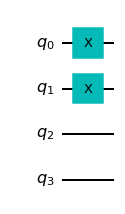

In [62]:
from qiskit_nature.circuit.library import HartreeFock

init_state = HartreeFock(es_problem.num_spin_orbitals, es_problem.num_particles, qubit_converter)

init_state.draw()

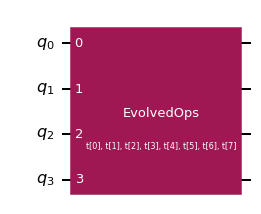

In [69]:
from qiskit_nature.circuit.library import UCCSD

ansatz = UCCSD(qubit_converter, es_problem.num_particles, es_problem.num_spin_orbitals, 1, init_state)
ansatz.draw('mpl', style='iqx')

# Ground State Energy

## numpy solution

In [72]:
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver

numpy_solver = NumPyMinimumEigensolver()
numpy_ground_state_solver = GroundStateEigensolver(qubit_converter, numpy_solver)
numpy_results = numpy_ground_state_solver.solve(es_problem)

exact_energy = numpy_results.total_energies[0]
print(f"Exact electronic energy: {exact_energy:.6f} Hartree\n")
print(numpy_results)

Exact electronic energy: -7.881146+0.000000j Hartree

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.876526512881
  - computed part:      -1.078193758682
  - FreezeCoreTransformer extracted energy part: -7.7983327542
~ Nuclear repulsion energy (Hartree): 0.995380044366
> Total ground state energy (Hartree): -7.881146468515
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.0139242  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [4.850322  0.0  0.0]
    - computed part:      [4.85436625  0.0  0.0]
    - FreezeCoreTransformer extracted energy part: [-0.00404424  0.0  0.0]
  > Dipole moment (a.u.): [-1.8363978  0.0  0.0]  Total: 1.8363978
                 (debye): [-4.66765719  0.0  0.0]  Total: 4.66765719
 


## VQE solution

In [82]:
from qiskit.algorithms.optimizers import SPSA, QNSPSA, COBYLA

optimizer = COBYLA(tol=0.001)
#optimizer = SPSA(maxiter=300)
#optimizer = QNSPSA(QNSPSA.get_fidelity(ansatz), maxiter=300)

In [83]:
import numpy as np

np.random.seed(5)  # fix seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

In [84]:
solver = VQEUCCFactory(quantum_instance, optimizer, initial_point, ansatz=ansatz)

gsc = GroundStateEigensolver(qubit_converter, solver)
gnd_results = gsc.solve(es_problem)
print(f"Qcircuit electronic energy: {gnd_results.total_energies[0]:.6f} Hartree\n")
print(gnd_results)

Qcircuit electronic energy: -7.881101+0.000000j Hartree

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.876480785689
  - computed part:      -1.07814803149
  - FreezeCoreTransformer extracted energy part: -7.7983327542
~ Nuclear repulsion energy (Hartree): 0.995380044366
> Total ground state energy (Hartree): -7.881100741323
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.0139242  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [4.86749056  0.0  0.0]
    - computed part:      [4.8715348  0.0  0.0]
    - FreezeCoreTransformer extracted energy part: [-0.00404424  0.0  0.0]
  > Dipole moment (a.u.): [-1.85356636  0.0  0.0]  Total: 1.85356636
                 (debye): [-4.7112953  0.0  0.0]  Total: 4.7112953
 


# Excited State Engergies

In [85]:
from qiskit_nature.algorithms import ExcitedStatesEigensolver

## numpy solution

In [86]:
from qiskit_nature.algorithms import NumPyEigensolverFactory

def filter_criterion(eigenstate, eigenvalue, aux_values):
    #return np.isclose(aux_values[0][0], 4.0) # for LiH
    return np.isclose(aux_values[0][0], 2.0) # But we have 2 free electrons (particles) right now.

#numpy_solver = NumPyEigensolverFactory(use_default_filter_criterion=True)
numpy_solver = NumPyEigensolverFactory(filter_criterion=filter_criterion)
numpy_excited_states_calculation = ExcitedStatesEigensolver(qubit_converter, numpy_solver)
numpy_results = numpy_excited_states_calculation.solve(es_problem)
print(numpy_results)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.876526512881
  - computed part:      -1.078193758682
  - FreezeCoreTransformer extracted energy part: -7.7983327542
~ Nuclear repulsion energy (Hartree): 0.995380044366
> Total ground state energy (Hartree): -7.881146468515
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -8.761130323789
> Total excited state energy (Hartree): -7.765750279423
  2: 
* Electronic excited state energy (Hartree): -8.743443660995
> Total excited state energy (Hartree): -7.748063616628
  3: 
* Electronic excited state energy (Hartree): -8.477633457354
> Total excited state energy (Hartree): -7.482253412987
  4: 
* Electronic excited state energy (Hartree): -8.260608156096
> Total excited state energy (Hartree): -7.265228111729
  5: 
* Electronic excited state energy (Hartree): -8.216286694068
> Total excited state energy (Hartree): -7.220906649702
  6: 
* Electronic excited state energy (Hartree)

## QEOM solution with numpy ground state solver

In [87]:
numpy_qeom_excited_states_calculation = QEOM(numpy_ground_state_solver, "sd")
numpy_qeom_results = numpy_qeom_excited_states_calculation.solve(es_problem)
print(numpy_qeom_results)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.876526512881
  - computed part:      -1.078193758682
  - FreezeCoreTransformer extracted energy part: -7.7983327542
~ Nuclear repulsion energy (Hartree): 0.995380044366
> Total ground state energy (Hartree): -7.881146468515
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -8.699854919748
> Total excited state energy (Hartree): -7.704474875382
  2: 
* Electronic excited state energy (Hartree): -8.602023956611
> Total excited state energy (Hartree): -7.606643912245
  3: 
* Electronic excited state energy (Hartree): -8.432654565619
> Total excited state energy (Hartree): -7.437274521253
  4: 
* Electronic excited state energy (Hartree): -8.357892464574
> Total excited state energy (Hartree): -7.362512420207
  5: 
* Electronic excited state energy (Hartree): -8.233184486727
> Total excited state energy (Hartree): -7.23780444236
  6: 
* Electronic excited state energy (Hartree):

## QEOM solution with VQE ground state solver

In [88]:
qeom_excited_states_calculation = QEOM(gsc, "sd")
qeom_results = qeom_excited_states_calculation.solve(es_problem)
print(qeom_results)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.876480785713
  - computed part:      -1.078148031513
  - FreezeCoreTransformer extracted energy part: -7.7983327542
~ Nuclear repulsion energy (Hartree): 0.995380044366
> Total ground state energy (Hartree): -7.881100741346
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -8.697881079626
> Total excited state energy (Hartree): -7.70250103526
  2: 
* Electronic excited state energy (Hartree): -8.60748786131
> Total excited state energy (Hartree): -7.612107816943
  3: 
* Electronic excited state energy (Hartree): -8.435925487268
> Total excited state energy (Hartree): -7.440545442901
  4: 
* Electronic excited state energy (Hartree): -8.358049872603
> Total excited state energy (Hartree): -7.362669828237
  5: 
* Electronic excited state energy (Hartree): -8.23274433318
> Total excited state energy (Hartree): -7.237364288813
  6: 
* Electronic excited state energy (Hartree): -

## Show energy differences related to corresponding ground state energy

In [93]:
def print_3_lowest_energies(results):
    for energy in results.total_energies[:3]:
        real_energy = np.real(energy)
        gap = np.real(energy - results.total_energies[0])
        print(f"Total Energy (Hartree): {real_energy:.6f}, Difference (Hartree): {gap:.6f}")

In [94]:
print_3_lowest_energies(numpy_results)

Total Energy (Hartree): -7.881146, Difference (Hartree): 0.000000
Total Energy (Hartree): -7.765750, Difference (Hartree): 0.115396
Total Energy (Hartree): -7.748064, Difference (Hartree): 0.133083


In [95]:
print_3_lowest_energies(numpy_qeom_results)

Total Energy (Hartree): -7.881146, Difference (Hartree): 0.000000
Total Energy (Hartree): -7.704475, Difference (Hartree): 0.176672
Total Energy (Hartree): -7.606644, Difference (Hartree): 0.274503


In [96]:
print_3_lowest_energies(qeom_results)

Total Energy (Hartree): -7.881101, Difference (Hartree): 0.000000
Total Energy (Hartree): -7.702501, Difference (Hartree): 0.178600
Total Energy (Hartree): -7.612108, Difference (Hartree): 0.268993


QEOM soltion can't have correct energies for excited states to be as near as the numpy solution.

compare with reference:
https://aip.scitation.org/doi/10.1063/1.1677704

Since we use very simplified model (less orbitals),
we could just see that the ground state and the first excited state are relatively correct for using UCCSD ansatz.

$1{\text -}{}^1\Sigma^+=-8.01605$

$2{\text -}{}^1\Sigma^+=-7.89982$ ,  $\Delta E_1=2{\text -}{}^1\Sigma^+ - 1{\text -}{}^1\Sigma^+=0.11623$

$1{\text -}{}^3\Sigma^+=-7.91520$ ,  $\Delta E_2=1{\text -}{}^3\Sigma^+ - 1{\text -}{}^1\Sigma^+=0.10085$

$1{\text -}{}^1\Pi=-7.86165$ ,  $\Delta E_3=1{\text -}{}^1\Pi - 1{\text -}{}^1\Sigma^+=0.15440$

$1{\text -}{}^3\Pi=-7.87555$ ,  $\Delta E_4=1{\text -}{}^3\Pi - 1{\text -}{}^1\Sigma^+=0.14050$